In [2]:
from pydub import AudioSegment
import numpy as np
import IPython
import matplotlib.pyplot as plt
import scipy, pylab
%matplotlib inline

/usr/local/lib/python3.4/site-packages/pydub/utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


### Utilities

In [3]:
def int_ceil(a,b):
    return (a+b-1)//b

def stft(x, fs, framesz, hop):
    framesamp = int(framesz*fs)
    hopsamp = int(hop*fs)
    w = scipy.hamming(framesamp)
    X = scipy.array([scipy.fft(w*x[i:i+framesamp]) 
                     for i in range(0, len(x)-framesamp, hopsamp)])
    return X

def istft(X, fs, T, hop):
    x = scipy.zeros(T*fs)
    framesamp = X.shape[1]
    hopsamp = int(hop*fs)
    for n,i in enumerate(range(0, len(x)-framesamp, hopsamp)):
        x[i:i+framesamp] += scipy.real(scipy.ifft(X[n]))
    return x

### File Input

In [4]:
class Sound(object):
    def __init__(self, sound, framerate):
        self.sound = sound
        self.rate  = framerate
        
    @classmethod
    def from_mp3(cls, path, start = 0, seconds = None):
        audiofile = AudioSegment.from_file(path)
        assert(audiofile.frame_rate == 44100)
        data = np.fromstring(audiofile._data, np.int16)
        
        channeled_music = data.reshape(len(data) / 2, 2).T
        
        left   = channeled_music[0]
        right  = channeled_music[1]
        
        mono = left#((left + right) / 2).astype(np.int16)
        
        if start != 0 or seconds is not None:
            if seconds is not None:
                segment = slice(
                    start * audiofile.frame_rate,
                    (start + seconds) * audiofile.frame_rate
                )
            else:
                segment = slice(
                    start * audiofile.frame_rate,
                    None
                )
            mono = mono[segment]
        return cls(mono, audiofile.frame_rate)
    
    @classmethod
    def from_spectrogram(cls, spectrogram, frame_seconds, frame_rate = 44100):
        # window used for fft
        frame_len = spectrogram.shape[1] * 2
        # use a hamming window of the same size
        smoothing_window = np.hamming(frame_len)
        
        num_windows = spectrogram.shape[0]
        
        frame = 0
        data = np.zeros(num_windows * frame_len)
        
        for t in range(0, spectrogram.shape[0] * frame_len, frame_len):
            iffted = np.fft.ifft(np.concatenate([spectrogram[frame], spectrogram[frame][::-1]]))
            iffted = np.real(iffted)
            iffted /= smoothing_window
            
            data[t:t+frame_len] = iffted
            frame += 1
            
        return Sound(data.astype(np.int16), frame_rate)
    
    def short_time_fft(self, frame_seconds):
        # window used for fft
        frame_len = int(self.rate * frame_seconds)
        if frame_len % 2 == 1:
            frame_len += 1
        # use a hamming window of the same size
        smoothing_window = np.hamming(frame_len)
        # store the frequencies inside big matrix
        num_windows = len(self.sound) // frame_len
        
        spectrogram = np.zeros((num_windows, frame_len//2), np.complex64)
        for frame in range(0, num_windows):
            t = frame * frame_len
            sample = self.sound[t:t+frame_len]
            ffted  = np.fft.fft(smoothing_window * sample)[0:frame_len//2]
            spectrogram[frame] = ffted
            
        return spectrogram
    
    def _repr_html_(self):
        return IPython.display.display_html(IPython.display.Audio(self.sound, rate=self.rate))

In [6]:
trumpets =  Sound.from_mp3("data/fur_elise.mp3", 21.5, 3)

In [12]:
trumpets

<source src="data:audio/wav;base64,UklGRrwJBABXQVZFZm10IBAAAAABAAEARKwAAIhYAQACABAAZGF0YZgJBABdySXNe9Ew1j7bkuAi5vLrCPJU+M3+UAW7C9IRiRfaHMchRyZMKt8tDzHSMzU2MjjMOQo72zs6PCU8pju9OmI5hTceNS0ysy7SKpUmByInHe8XXBJlDCgGuv8k+YDy5Otx5SbfFtlY0wDOD8mIxH3A8LzyuYe3yrXBtIG09rQYtti3RrpevQPBJ8XAyb/OHtTu2S/g5Obv7Tj1n/z5AyMLERK5GAEf4iRdKmQv7jPzN3E7bD7vQPdCdERzRehFxEX0RH1DdkHhPtQ7Vjh/NFQwxivjJrUhNxxEFtwPGAkOAuj6sPN77F/lbt6q1xjR28oSxci/E7sBt5+z4LDKrnetBq1zrbWuwLCDs962v7oivwXEaMk3z1zV1duk4rnp//BQ+Kj/5gb4DdEUZhuuIaInQy2JMmw36TsDQLJD6kaQSZ9LB020TapN9UyYS6lJMEc8RNNA5zyHOKQzUC6cKJsiUBzMFR0PUghkAWL6UfM/7EflfN7t16zRx8tQxlTB37wWuRi25rOBsvqxU7J1s061zrfeuoO+y8Knxw3N/NJZ2Qjg6ObW7c70vfuKAioJiw+aFWMb7CA9JlUrNDDQNBw5Dj2pQOBDmEbKSGhKX0u3S3hLnUo7SVRH9ET4QWI+OjqWNXsw8ir3JJceyRelEDgJsgE4+tLyj+tv5I/d9tay0MnKY8WZwIO8Ibl3toW0PLOksrKyZrO6tLe2Xbm4vLLAQMU/yqHPbtWE29rhV+j07pj1Mfy0Ag4JNg8eFcsaNCBTJSEqky6UMg82Cjl/O389CD8pQOVAMkEdQZdAij8CPgU8lzmnNi8zKC+rKsElcCDEGsMUgg4MCG8Bt/r681ft2uac4MnaeNW80KbMPclwxizEb8IqwW/ASMC8wMzBasOVxUbIc8sUzy7Trtd/3I3hxOYq7J7xC/d7/NkBIwdhDIsRmRZ1GxwgcSRgKN4r7y6dMfkzBDa3NwY55TlWOkQ6wjnVOIk3yzWdMwExBi6gKuMm1yKMHv4ZNxU0EPkKjAUAAFv6y/Rw71vqnOVG4WHd6tnd1k/UT9Lg0OzPe8+QzyjQTdED00rV/9cl27jeueIE54jrJPDL9GT55/1KApwG3QoMDx4TAxekGvQd7CCTI/klKCgTKrQrGS0wLv0ufC+jL2svzC7NLWEshCovKGElNSKoHs4aqhZVEuoNagnGBAcAL/tF9lfxg+zm55jjpd8V3O/YN9b00yzS2ND2z4LPe8/Mz4TQntEu0y7Vrtep2g7e0OHb5Sbqhu7g8jn3h/vL//IDAQjpC6cPKRNrFmIZEBx3HpsgbSL9IzslICauJu0m5iaRJvIlDSXWI1EiZiANHkMbIRi4FA8RLg0cCdEEQwB9+4/2jPGK7Jzn3OJj3kPajNZV06vQjs77zODLRcssy5bLfMzWzaXP5dGM1JzXGtsC3z/jp+cq7LXwR/XR+Uf+tAIUB2oLow+yE54XXxvzHkMiRSXzJ08qVyz7LTIvCjB0MG0w+C8oL/stbCxvKgQoKSXuIVsehBprFicSww0/CYMEiP9b+gv1pe876uTkt9+72gnWrNGzzSbKHceoxMfCgsHnwO7AgsGkwlDEicZZybTMldDy1LnZyt4M5HnpBu+h9DT6vf83BZ0K5w/7FNQZZR6bIoAmEypnLWIwAjM7NQY3azh0OR46aDpLOrs5qjgUN+00LTL6LmYrcCceI3AeiRlnFAEPXwmBA3b9R/cU8fPq8uQp36TZfdS6z3PLw8e2xEHCVsDxvg++rL3WvZW+9r8BwrrEGMgHzHLQNdVG2onf+eSN6kDwFPb5++ABvgduDe0SMxgnHb0h5CWbKcsseS+kMWQzvzTBNYA2/zY0NwY3cTZ3NQ40NTLqL04tYSomJ5ojtR91G84WvRFFDIQGmwCG+kH08u2156zh7tuQ1rTRWs2HyTfGasMjwV6/K76PvaG9Tr6sv7fBaMSnx1rLe8/708jY791j4x3p/+4A9QX7BQH4BtYMohJBGKMdsCJXJ4orUi+tMpo1FjgoOtQ7Ej3NPQ0+0T0SPcI7/jnaN1c1dDIrL3wrZSfwIh8eABmWE+YNAQjnAaf7UfUG79ro8eJa3R/YQ9PUzuLKYMdQxK3Bhb/6vR698LxzvaO+fcDuwvHFhMmdzS/SHddH3JvhFuet7FbyBvjE/YwDPwnXDkMUdBlQHtQiDScAK68uGDJMNTY4vTrWPHo+pz9JQGVAA0AkP7Q9qTsKOdo1JjIGLpApxiSVHwUaMhQmDvoHwAGP+4P1qO8N6sTk098v29rW0tIiz9nLAcmvxvbE18NOw1jD+8M1xQHHWclAzKXPdNOZ1xLc3+D35UTruPA69sT7NgGLBq0LkBApFYIZox2PITclnCi4K34u6DDsMnw0mjVZNr82yjZnNpo1dTT3Mgwxry7mK7Io+yTXIEwcdBdDEsQMIwdzAdz7bPYm8RHsJ+dv4vbdytn71aDS08+PzeDLycpNymrKF8tOzAjOL9DE0rTV+tiD3E7gYeSp6Brtt/GB9mH7QwAUBckJVw7CEgMXHBsBH6kiBCYRKcYrMC5JMAoyZDNcNOk0DTXNNDw0aDM/MsEw8y7dLHYqrCeGJAUhJx3uGG4Uqw/ECswFzADE+7r2xfH37GXoDOQE4GbcQdmT1nbU8tIM0snRGtL80mjUSdaQ2CjbC94q4Xbk9OeW62LvTfND9zr7Hv/pApUGGgqADb4Q1hO/FokZMByoHvMg/iLKJEQmdCddKPgoOykjKcMoFigNJ7YlEiQVIrkf5ByfGe8V5BGRDQoJWQSP/7v67fUt8YPs++eb42XfYduR1/7TstDIzUzLPcmnx4nG+MX4xX7GgMfhyKnK1Mxiz0jSg9UW2ffcFOFO5ZzpAO5y8t32L/tp/34DYgf9ClAOYREkFKAW1RjHGoUc/x05Hy0g2iBIIXIhUyHsIDggMh/RHf4bxRkiFysU4hBSDY0JrwXAAcj9zvnw9UHyuO5k61vou+V/457hFuD43kDe8t0O3pjek9/m4IDiWuR35troi+uG7rrxJ/XI+I38XwA8BBoI+wvDD2UT6hZTGpUdmyBaI+QlKCgXKrsrEi0pLusuSy85L74u8S3ZLH8r1ynlJ7MlLCM/IOQcIxkXFdMQWgzCBxADWP6c+eD0J/By6+HmeeJL3lvar9ZV01nQz83Ey03KcskvyYfJbcrky+HNWdBG06/Wf9qx3jXj++cC7SjyUvd0/I8BkgZqCxUQjhTLGMgceyDyIyInECqzLAEv7zB/MqgzdTTbNNQ0ajSoM4ky+jD9LoUsiSkEJvkhdR2WGGUT+A1dCJQCsPzB9tXwAetR5d3fotqm1ePQXMwjyEXE2cD2vaS77rnQuF+4m7iAuQK7FL23v+fCrMb3ysjPBNWf2oTgoebl7EbzqvkAAD0GUAwxEswXHR0jIuomaiuOLz4zeTZJObA7nD0dPy1A10AaQfNAXkBSP7g9nzsNOQQ2ezJwLvApAiWuH/MZ6xOxDWYHFwHJ+oT0Ve5U6IfiAt3O1wPTuM4Cy9/HWcVxwyjCf8F0wQHCMcP9xF3HP8qBzRHR9tQo2ZrdOuIE5wDsKfFv9sf7OgG1BiUMgRGxFrEbZiDGJNEogSzHL5Qy6TTcNmQ4jTlIOpI6azrJOaA4+DbiNGMydS8MLC8o1iMaHwwaxhRED4kJpAOh/Xz3P/H66rnkmN6i2PLSnc2wyDfENsC7vOC5oLcGth215LRctXO2I7hjuiW9ZMAUxDHIo8xp0WzWq9sY4ajmVewP8tH3nf1vA0MJBA+OFNcZzx56I9Mn0Ct1L8UyvTVEOE860DvLPDU9FT1lPBw7MTmxNqgzFDACLIInsCKfHVIY1BInDVgHcwGS+8b1IPC06pHlw+BO3DTYiNRU0ZjOVcyNykvJkMhby

In [8]:
begin =  Sound.from_mp3("data/fur_elise.mp3", 0, 3)`

In [13]:
begin

<source src="data:audio/wav;base64,UklGRrwJBABXQVZFZm10IBAAAAABAAEARKwAAIhYAQACABAAZGF0YZgJBAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAPn/AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA+f8AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA+f8AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD5//n/AAAAAAcAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA+f8AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAPn/AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD5/wAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHAAAAAAAAAAAAAAAAAAAA+f/5/wAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD5/wAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA+f8AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD5/wAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA+f8AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD5/wAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD5/wAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAPn/AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABwAAAAAAAAAAAAAAAAAAAAAABwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAcAAAAAAAAAAAAAAAAAAAAAAAAAAAD5//n/+f8AAAAAAAD5/wAAAAAAAAAAAAAAAAAAAAAAAAcABwAAAAAAAAAHAAcABwAAAAAAAAAAAAAAAAAAAAAAAAD5/wAAAAAAAAAAAAAAAPn/AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHAAAAAAAAAAAA+f8AAAAAAAAAAAAA+f/5/wAAAAAAAAAAAAAAAAAA+f/5/wAAAAAAAAAAAAAAAAAAAAAHAAcAAAAAAAAAAAAAAAcA+f8AAAAAAAAAAAAAAAAAAPn/AAAAAAAAAAAAAAAAAAAAAAAAAAD5/wAAAAAAAAAAAAD5/wAAAAD5//n/AAAAAAAAAAAAAAAAAAAAAAAAAAD5/wAAAAAAAAAAAAAAAAAAAAAAAAcAAAD5/wAAAAAHAAAA+f8AAPn/AAAAAPn/+f8AAAAAAAAAAPn/AAAHAAAAAAAAAAAA+f8AAAAA+f8AAAAAAAAAAAAAAAAAAPn/AAAAAAAAAAAAAPn/AAAAAAAAAAAAAAAAAAD5/wAA+f/5/wAAAAAAAAAAAAAAAPn/AAAAAAAAAAAAAAAAAAAAAAAABwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD5/wAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABwAAAAAAAAAAAAAAAAAAAAAAAAAAAPn/AAAHAAAAAAAAAAAABwAAAAAAAAAAAAAAAAAHAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABwAAAAAAAAAAAAAAAAAAAAAAAAD5/wAAAAAAAAAAAAAAAAcAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAcAAAAAAAAAAAAAAAcAAAAAAAAAAAAAAAAAAAAAAAAA+f/5//n/BwAHAAcAAAAAAAAAAAAAAAAABwAAAAAAAAAAAAAABwAAAAAAAAAAAAcAAAAHAAAAAAAAAAAAAAAAAAAAAAAAAAcADwAXABcAFwAXABcAFwAHAAcABwAPAA8ADwAPAA8ADwAHAAcADwAPAA8ADwAPAAcABwAHAAcADwAPAA8ADwAHAA8ABwAHAAAABwAXABcAFwAXAA8ADwAPAA8ABwAPAAcADwAPAA8ADwAHAA8ABwAPAA8ADwAPAA8ADwAPAA8ABwAPAAcABwAAAAcABwAPA

In [14]:
tstep = 0.5
Sound.from_spectrogram(begin.short_time_fft(tstep), tstep)

<source src="data:audio/wav;base64,UklGRrwJBABXQVZFZm10IBAAAAABAAEARKwAAIhYAQACABAAZGF0YZgJBADXAI4EnwKYAKr+r/zB+t/4F/do9dLzSfLa8KnvrO7I7f3scuwZ7Obr2evz60zs5Oyi7Ybune/N8DDy0vN19TD3EvkA+/v89v7kAN8C2gTIBrYImApgDPYNZg+8EOwRAxPbE4wUFxV9FaMViRVKFdgUTRSOE54ShxFjEBoPqg0UDFkKkAivBtoE3wLwAAP/Ff0z+175lvfn9UT0yPJl8TXwHu867nzt5Oxy7D/sMuxY7L7sPO3u7cXu3O8Z8XzyEvS09Xz3XvlM+zv9Qv9JAVEDPwUtBw8J8Qq5DE8Oyw87EZEStBOlFH0VIhaUFsYWxhatFlQWyRUkFUAUQhMSEskQWQ/DDRQMWQp3CIkGmgSsAr4A0P7i/AD7OPl89831RPTu8svxtPC279/uU+7h7aLtiO2u7e7tU+747tDvzfD98Ufzw/RZ9iH43fml+4f9df9WAVEDMgUUB/YIvgpUDOkNZg+8EOwRAxP0E78UVxW8FfwV/BXJFX0V/hRZFHUTeBJUERcQmw4SDWMLpwnSB/EF9gP7AQAA+f3++xz6Ovhy9sP0OvO+8VvwK+8t7lbtpOwZ7MDrjeuN68DrGeyx7G/tYO6D783wPfK582j1MPcS+Q37Ff0c/woBEQMMBQcH6Qi+CoYMKQ6lDxURRRJcE0AUCxWWFfwVIhYIFskVcBXlFCcUNhMfEuIQjA8PDm0MsQrcCPsGAAUFAwoBHP8h/TP7Rflw96f1BfR88hnx0O+s7q7t5Ow/7M3rgetb63TrwOsy7PDs1O3f7g/wcvEH86r0ZfY6+DX6MPxF/j8ARwJbBFYGRAgmCvsLtw1MD9UQOBJ1E3MUPRXvFWEWrRbGFroWehYIFmMVfxR1E1ISCBGYDwMORwxyCpAIlQaOBHkCcgB4/nD8dfqG+LH26fQ687HxTvAe7wfuFu1M7MDrW+so6zXrW+vA61jsI+0h7lHvmvAX8qzzW/Uk9x/5Jvsh/Tb/SQFdA3IFbQdbCUoLEg3BDkoQuREDExoUCxXJFVQWuhbsFuwWuhZUFrwVCxUnFBwT3xGJEA0Pdw28C+cJEggjBigEOgI/AFL+Vvx1+qD45PZC9cbzfPI/8Q/wHu9T7q7tPO3w7OTs/exW7eHtk+5q72jwsfEU85D0M/b799D5vvu5/cH/rgGqA7EFoAeOCXALOA3nDn0Q7BEpE0AUJBXvFZQW+RYsFywX+RagFggWShVZFEITBRKvECYPhA2WC6cJrAelBYMDVgE2/xX9DfsF+Qr3KPVg877xQvDf7qLtmOyz6/Xqd+oR6vjpBOpd6s/qgetl7Hztue418L7xYPMc9f72Bfka+yH9Nv88AVEDWAVgB1sJPQsFDZsOFxCHEcQSwROlFEoV1hU7FlQWOxbvFX0V2BQNFBwTBRK8EEwP0A0UDFkKhAiVBqcErAKkAKr+lvyo+sb4/vZP9azzF/K08GrvYO5i7Yvs2etn60HrTutn683rWOwW7QfuHu9b8MvxU/MC9b72rPib+qP8t/7KAPgCDAUhBykJFwv5DMEOYxDfETYTTRRKFRUWxhYsF14XXhdFF+wWbhawFcsUwROeEjsRsg8PDlQMiwqqCK8GmgSGAn4AeP59/IH6rPjk9jX1hvP98afwd+9t7ojtyuxY7P/r5uv/6z/ssexi7TruUe+O8OTxYPMP9df2ufio+q/8t/6xAMUC2gThBtwIywqTDEIO2A9UEaoSwROlFGMV/BV6Fq0WoBZ6Fi4WvBX+FA0UAxPGEXAQ5w5RDaIL2gnsB/0F6QPIAbT/k/2M+4T5r/fN9QX0SfK08Dfv4e2x7LPr6epd6gTquOm46dLpN+rP6prrmOzU7Tfvp/BW8h70GfYh+EL6Y/yq/tcA+AIZBUcHdQl8C14NJg/iEHgS2xP+FAgW0xZrF+oXKRg2GAMYnhcSF0gWVxUzFOoSehHkDykORwxZCkQIIwb2A8gBqP96/Uz7K/kk9yj1R/OL8envbe4K7fPr9eoq6obpFOnh6O7oLemf6VDqNetM7JXtEe/A8HzyavRl9nr4qPri/Cn/bwHDAwoGKwhMCkcMTw4kENMRTxOZFLAVoBZeF90XHRg2GB0Y3RdrF8YW4hXYFI4THxKWEM4O7AwKCw8J+wbNBJ8CZQBS/jD8D/r79/P1EvQ98qfwK+/I7Zjsjeu26h7qrOmG6ZLp0uk36vXq2evk7CHukO8/8fvyw/S+9sb49Poh/Wj/ogHpAyMGUQhlCm0MaA5KEPkRghPlFCIWHxfdF3UY2xgaGRoZ5xh1GOoXEhf8Fb8UaBPfET0QaA5tDFkKRAgjBgIEuwGO/1T9M/sS+eT23PT78ibxkO8h7srsmuup6tLpRunu6NTo7ug66cXpg+qB67Hs++137wzx4fLQ9Mv27PgN+0f9m//hATUEbwaQCLEKxgy0DokQHxKOE9gU/BXgFp4XHRhpGIIYaRgdGIUX0xbiFcsUghMFElcQgg6TDJgKdwhJBgIEyAGC/xX9wfqG+Ez2K/Qj8kLwhu7k7GfrKuoU6S/ofuf/5tnm2eYM537nI+gH6R7qZ+vw7JPuaPBW8l70i/bG+Cb7h/3n/0cCpwT7BkIJcAt3DX8PYREQE4wU4hUGF+oXmxgnGYAZmRlzGRoZqBj3F/kW1hV/FAMTVBGMD50Nlgt1CToHDAXFAnIAK/7k+6r5fPdP9TrzTPGQ7wfumOxn613qeenI6FXoFugW6Dzoruhg6UTqZ+ux7C3u0O+L8XrzdfWW98P5F/x4/soAKwNyBawH5wkUDBwO8Q+tEUITpRTvFfkW0RdcGLUY9BgBGdsYaRjEF+wW4hWZFCkThxHYDwMOCAzaCbkHfwU3A8oAhP49/AP61feb9Ybzi/Gp7+7tcuwb6wTqFOlJ6L3ncedl537n8OeI6GDpd+qz6yPtxe6O8Hzyd/SY9uz4Wfu5/QwAeQLmBFQHpwniCwMO8Q/TEZsTJBVuFpEXghhNGcwZMRpkGkoa5RlNGY8YhRdUFuUUXBO5EfEP6Q3VC6cJYAcZBawCTAD5/Zj7Rfn+9tD0u/LA8PjuSe3N63fqU+li6LHnMuf/5v/mS+fK53voYOl36sDrSe347trw1fL29D33kfn++2v+1wBdA8sFOAiLCtMM5w7vENASjBQiFmsXghhzGSQasBrvGu8avBpwGswZ9BjRF4cWFxWCE60Ryw+3DXwLKQnVBnQEBwKo/y79wfpU+A327PPL8cPv7u0/7M/qeelV6HHnzeZn5kHmTuaN5v/mvee76ATqW+vk7LnutPC78un0MPed+Qr8eP7kAF0D1wVECJgK3wwAD+8QtxJZFMkVBhcDGOcYmRn+GTEaMRryGXMZwRjdF9MWfRX0E14SlhCoDqAMcgpRCAoGqgM8Ad3+ffwp+uL3p/WT85jxw+8U7n7sD+vr6QfpSejK54vni+e95yPoyOjF6dzqJeyV7UTvMvEh8yj1Y/fQ+TD8kf79AIMDCgZqCLEK7AwmDy4RAxOyFDsWkRe1GKYZZBrWGhUbIhv8GpYa5RkBGfcXrRYxFYITuRHLD6oNcAspCcgGTgTuAYL/CP2b+iH4zfWg84vxg++i7fPrauog6QnoJed05g7m3OUC5k7mzeaL55Xo3ulO6+Tsn+6a8MjyD/Vj9935Vvzq/mIB3ANjBtAIPQtrDYwPhxFoEwsVlBbRF84YmRkYGooasBqwGlca2BkNGR0Y7BZ9FfQTOBJKEEIOFAzaCYYHGQW5AkwA3/1M+9/4f/Y49P3x3O/77T/sqeo66QnoGedO5rblduV25anlG+bN5rHn1Oge6sDrle2D74vxufMZ9ob4Dfut/T8A6wJ/BQUIfwrsDCYPOxFCExcVxhY2GHMZcBovG7obBhwsHAYcuhsVG0oaMxnqF24WyxQDExUR9A6tDGUKBQilB

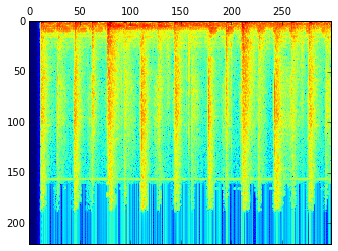

In [231]:
plt.matshow(np.log1p(np.abs(begin.short_time_fft(0.01).T)))

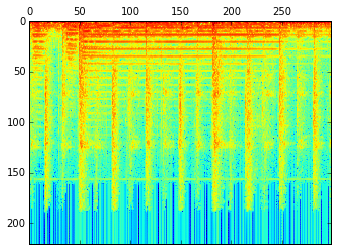

In [230]:
plt.matshow(np.log1p(np.abs(trumpets.short_time_fft(0.01).T)))

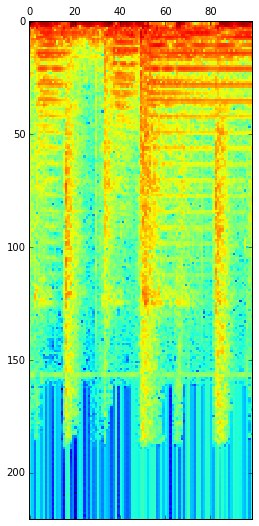

In [174]:
plt.matshow(np.log1p(np.abs(filename.short_time_fft(0.01).T)));

In [238]:
tstep2 = 0.2

begin_trumpets = ((trumpets.short_time_fft(tstep2) + begin.short_time_fft(tstep2)) / 2.0)

Sound.from_spectrogram(begin_trumpets, tstep2)

<source src="data:audio/wav;base64,UklGRrwJBABXQVZFZm10IBAAAAABAAEARKwAAIhYAQACABAAZGF0YZgJBACs59cBQwVOCdgJYAkcCQII/An7DQIQ0A/HCvwE/wZ0EJYV1Q99DNwNcwuEC5kN+A2ZEVMUYg8xC7wQ9RZOFiYT8BKGF5YYXRToEWoQExKJF9YahBrHFxMWhRX/ErgS/xeRG4kYHRWGEyMSLBYVG10YYxZcGdAcrSBlH0Ib9h0iIx0niCrzK6Yr5SglJ0UorislMLAu9CrpKcMnJifbJ9MoxCowKQ8lxCGBIqQlqSMkIzgnjydxJ50mCyX0KgwuwieuI0IjlyTgJXciCyBJIVIfjRs4G3Ubbxu2GzsZkBdeFT8Png8CFUYSzgnrBlEKfQqkB0IGjwYgCQMGqQBaA7kDKgCi/bH4Kvm5/O34UfXi9fz2XfeQ8+DuI++O71zrvOok8zr4fPLx6r3oSuty7DvqZOuh7hzs8OWO43bltefS5+DkM+IN4tfiqOVX6IbnEuZO59rrte296VHnYuiz6jDrtOeq5z3piOdV6HLoNOjk6gDpheUm5ZvmZujg4/fe1uBB4ebeJ9zG2GbYB9kz14zV8dJm0EzSh9EszCrJB8YDxO3EOsUDxmvFisTSwl27dbkRwMXB8r8mvz6+bL+EwI7AgcEzwTnBgMNIxM/CkcPaxTLDe8FKxmTIGsdtxcDDFMdfykjJlsiIyF3JL8t2yqDJoswmzSbLx8ykzSnRotYh1EzSONSe1X/a4d6S3gjaktiL3h/fsdnm2APbnduY2crXQNcZ1iDY2dwC3ojcetvB2xjeWN9V37PhjOQ85aLiDeCj45zpvuyn7Gjq+ute72LwMvYN/C/6nfno+gz9ZgPNA68A1ANfB1UKrAq3BhIGFwbYBg8NgA+KDicSDRIBDTALUwoGCqAJiAebBlUFdAgZD6INmQgaCecO0A/FCDsJlQ/DEbkSWhWmGwcdYBhgGrAgxiWLJjQmnCulK3snfCqzLUAwozFsLbArDC4aMss0WC/yLGozbzT8MPwxLjWxNjc1BTN2Mmkx+i6XLqsuhCwlLdQs7ib7I4gkCST2IZcdlhqgGL0XQRyUHgYYbBLGFQMZZxQqE44Y/xayEPIQABTQEwwTehNhE0ESgw+UDtcRtRPhFBQVERODFxwcHhvHHdkg/yDNIKQiHiY/Iu4dWyMeKTgpQyemJrcmhyaHJekjPyOoIo4lZiX9H6gjPSWdHVQXOhPjGOIc6hSqEmoV2hSxEN0OWRRkFAQPDw6GDhYLkgRIA+EENASwAzQBBv4c+v34TP5t/hf7dvu2+bz41Plq+Zv5jPeS9Dv2vvbw9Zz4IPcn8tfyrvW39vf0/vCj8jP3//XO8wfziPDc78/yWPWR9B3z3/PZ86DxWfD48PzvTe2G7970v/KF7onznvY08w32qfhg9Rz09PbM+9X6NvhD+ij87v8X/v/3+vZ79u77Ov1l9x/8Uf9R/s39D/s3/4QAI/9wBYAJ/wdTApMD8wssBRv7zgDKB5QG/gEJAPkBcQHtAp0JFwgxBSUMfA+rDG0KuQxXE7sUaRYsG9gc8x5PGyEXLhpEGAkYaxwKG8YaQhtzF+QU+Re1HeQcJxi6FqAV7BUHG3MgPx2xFLcUxxqbHSscqxgcGrAbfxijGgUbRBYvGbQY0BAXEsQVIRLkDuEM/Az+ENMP+w4PEtAJWAEbBm0KvAgnA8P+5f1n/an+6Pn58177wv9r9ujvEPKT8Tzsiu3B87L03PD+6hnr5e4p6mnoOuuV6Lnrre7e6kXq9eqe7kHsM9/E3QDm2ueQ6N3tU+wo4HXeaeix55HeWd4+5ZDkIt1O20Xb9NV+1trcn9w217TQatG11STRQtEs12zWfNNf0XLQ2M2JylXL8ssWywXKVsdQxBrGa8q/yW/FdcGAw13Gm8EHwQ7G/sXuwyjEh8ONwsrE8MX3xQ7Ii8aZwyPFAshsyhnLeskOzdPPmcngyj3Rw88a0XfS28+U0xbY59ad2FXbY9nN2xvdIdg52nLfJOBn4E7jwOQm4gbl5ef35OLi6t9j4tTls+My6mjwgOqi5Uzpg+/J6xHmYu3W7g/nEOvC8Rvw7uvK7Nv0OvRA7LLvwvXE8uDtt+va7ATxsPOS8zzwuO1e9K32g+yh64L4/gCC/yX9UQDFBZQH6QU9A0wAcQTMDL0O8w6dDhINXAwODNYNVg6/E/QdIx5ZGBcY5SCXKLYllSPqKbYxXzBoLF0wyDO6N1w7wTN0K4AuCjcOPFM69DYDNXkuYSkNMeM26C/3K+wuUCyzKgcw1jAgMBMx8jHcNEM0ETfeOpI43zs3QpBI8kccPXU7Nj/pQARIrE1cSnlFFERyRHxKBUtlROVJWk4ZR51D0ketR48/Rz5ZQ/5FTUNJPWA+yUCCQBQ9LDKQK5YsXCwKKhwsCC6FJxwidySjKegl5h1vHnwbXBShFVgdyB7gGGoYrRf4F3wdJR6zGwgWXxShG38htCK1HXMZfBvEILoicxw6GzYhaiAaG80f8SheIkUYwxomH2MfPhyHFuwRHRJdGKMd/RYzDx8UCRWeEQUWHxXxD2MNSgdkBHwFDQJMARsAVPm0+s38yvxh/0T3TvMK9UHwIfQj85fomOgx61/nR+Nn5wXoO98S4dHkBuE63SHYqNtL4dvgFeEw2R7Vzt3K4TDew9mX3Rvj4OXG7sTy5O255QnkfuzS7RPqPOki72r22fJn8Q7xk/CT9CDxpe9J8zLzee1V6rT2HP6596HzJPPh9c/3c/YU9/35tfek9Yr6xPhZ9e74nvuD9i/sIfJ8/Rb2Z+1z9GUA0/6H+UD4w/Ky8kn1kfKj8N34/QIy+cPrg+vy8Tf5OvhX9h72KvM38trz2vae9AH0c/jN9Njvu/TX+of0PvFH+uT2ge+T8Q7yqfXR+L/1yPRC+OT/TQFE9NTv6gBOCdn8m/jPAQ8BXfqK/G8BYQbFCfkIOAg5A9oDchK6FaUPfBeuGlAQOBB1GJccjhwxG4kerBmjC/cNmBe3GGcZFxasDxAMawgKCSsJzwQcBlIGpQHKA3AJ8wd3/uX5YQBMA5gBlgP2/0L4gPy/BHsAafdt+Mb9r/cK8AH2qv0o+9Lz8feBAo/9d/ltAo0ECwKRAWL9JfxpA/kI/gB588P1SQDo+sr0b/z8/Tj3avAr7zL3bPZV7qztRuug6CLtGO9L7IHzT/pR7b7p4/Z99fbvlPUa/Kb7dvTs76nyufiS/h7/FvjD8QbwFPNM+vv2+/L8+hX7ovQg7jPp4+tb7Dfxk/dD8N7s/vB28ULzyfT980HxFuuf6xXw1egJ4ovoVO1S6BfkRual6WTqNurE6E7lmOfw7hfwFOwo6lnyt/r18ijue/Ol8iLyLfbL9878agXQBgADZf+zAq0KkQYkAocHoAq+Bkn97v52BWgBFQK5BKL+y/Qf84b6x/Ui69fuoPX38RHq1uem6hbtZu176Eng7uJH7mfwgeaU3VLg7+C22uXc5uIV4f/XHtxD6XXneeWW49HeZ+RO7GHxXu0v6afuJu9J7YLuF/X2/nwDAgdDB/UCL/xF9RD7eAXtAj/54u/Q6rXtG+4f6B7m2ezj8mTs2+d/7F/tK+9S8UbyL/Rm8r/02PYC8TnxeP5UC10IGQGWAWr/Xv6hBqsUTRyTEKIG+Ak9DDcXER1iEhAVZh5QH18dBxgZE5wOyxIoHvgcqRT4FeYgxSUGHxYbcyBIIb4XsRdKHmgbuRdGF+YWlxDyCU4NMQ+eEGIUuhCTB/L/8QbZF1UZ5Q5ACosN4BfWHfcUawp2Dogg8yepGvkUuh1CIXEXtQ2vGXAqCyYhIGAjGyHaHpId1hdJF+MdeSQGIOQa1SEvIWwYMRStGssjxxjnEnElli+NJQ0eVx/VFNMMshlHJTcmjh5HGKETGgZ5CoEfiRsaCbcIIA4vCS8FRQPr/vL9c//aAh4HvAniC38Fy/oP/

In [135]:
filename

<source src="data:audio/wav;base64,UklGRqxYAQBXQVZFZm10IBAAAAABAAEARKwAAIhYAQACABAAZGF0YYhYAQDe55foze409un2aPOP7prr1e6x9FX4c/d074zkVeKH7tL44fGq62HxvPK37L/p3O7K+LH8ofbY8W/4fgBj/ob50PuIBEAJ9gMS/sn8nfy9/78G6wrmCH0Dkv8X/hL8cP3rAe0AaP3I+dX1UPiM+kL2PvXx+UP/ef95+M304PiQ/XQAVQGsAQ8BWfzD+EH6cAA/B5QFVf87+yH5tfri/JL+zP6w+5/4LvbY+Kv7yvfI+pIBKwHP//YAEQkIE78SCA3uCIkI5wmECEMIgwpbCHICJgHpA6ADY/8o+yX7Nfs59WLwp/CC72frNuWN39nfquKR4WrfPt9p3GfVKdPM2IXcl9iU0BvNldED1bPR+cxCzoPS79CMzo7OaMzNzNvOGM+E0oXVnNKczjrOLNC30dDUYtqR2yPWi9BUz17Uqtk31+PSANH4z3bSU9am2UrbbNew1RHaO9mB0nvPttGC1hjXu9DNzh/TmtMJ0abR4tZj27baqtnD25DfXeEq3uvZ9NgN2ovat9jU1NrSbNUZ10DVbta/2nzaktWg0MXM7MxqzyXN7Mi2yIDKMMlTxODALcJUxyjKgsdWxWjHhczn0CfTVtSK1BzWJNbC1ITXv9rL3PTbdddx1xvcGd813KHZsN6Z4WXf29584OHiv+IG4aPh6+Wp6ALluuJe5EXpfPBG8U3wQ/HR8Gz1mvzx/w0A5/7r/8IAU/8J/kH+TwArAWb/Bf4R/wsChgVnCIAIuQWoBCIGQAZlBz0LDAzDCnEJrwY/B5oLIQ/DDxcPcBGJFHMWthlsG7waABxaINQkASZdIkke0iDBJvEpeCrmKDco/inuLA0w/i9tL5gyDDQQMmMw+SxjKcIprykxKFcnDCafJ1UpSCeBJ2UqpiuBKvUnkSa/KDwuezGJMmo1mTXwMh4yUzTROUs/KkGePEw2+jd7PCM90TvSOIM4QzqrONE3ZDkXOuA4TzYgNqQ3gDd4NvszxDIqNqA44TYGNZY07TOUM0QzaDF0L4stOSxNLU8uCC8/L0AvNDOhNGgvWCwULAEsfy16LrYtqCrWJuollCVgI/kgXx8sH8UcWxZcEwcVrxbEGLMYUBX5FNcY4BokGqUadhv3HLof2B2PGk0b8BtgG6IYBBY9GAYasxg+F64YrxxEG54WphbDF1sXshVbEm8QxRFiE24SnREYEmASxBN2FCMUxxSzE9IQ9gwnCKAEewGu/+gAMgAb+6v1FfWA+qP+Wf2a/Dj+6f7t/VH7Q/pz/LP9//yN/Jz80PuN+hv7G/29/zkBwf88/kL99PtY+5P6jPr5+uf4r/V49HP1W/bJ9Vn0P/L470juTesP5iniQeD035DiluK1383g+eIW4n3ffN333YreGt4G33HhnuLB4Ujig+Pn4mfi9OJC5droIute7JHuzPJ59tL2oPav+Ev8qQAzBacIKwpvCh8Mvg5fDTkK+gkhCc0GQgRKACz+WP/5/4D+ZP3a/jwA2v7z/SUAjgIfA0YCtgB0ATgEagXeBFAC9f7N/aH+mgBTARYASABrAPz9RvzU/boA5gFmAFz+I/4X/jP9s/2L/uf+OwCZAVkDNgWiBboFPAU9Bc4GxwZwBiMHigYIBpEETgKvAnUA3Pva+737kfms+E/2mPP48V7vRO1Y7K3rzekd5kPj2uLr44Dj2uD13aTcfd5b3unb3N063vbbgN0e3oPeE+DO3gLfjuAm4LffCt4j3drfueF64HjeWN2H3aXe1N9R4OLfpt1D2RbWb9ZE1kjTRdH4z6zMS8ttzHnKfcfVx+PISMhNxrLFosioyn3JhMiCyI/Jz8pnyU/IxMq6zInMN8u+yMPIXctJzdjOLs4nzVLQL9MP0/LRQNDr0BrTctOr06XTYdMt1P/SAdFc0pDU1NTc1GHV6dNN0RjS59T11fXVPtaS1VLT39MM19nXpdgd2gnb492a4KjiSeSY4+fjd+VE5ubmXuaI5mrnuual56vqU+y66/rp+Oll7N7u5PA78231z/X29Fz1KfZw9pj2LfaI9h33BPjN+/391fwe/hABmwIIAy0DWASaBBADJAIbAR4AjADQ/3b9rvxZ/X/8kvkw+Z79lQB4/6r/XQJgBBwFmAWRBPgAwP43AJ4BsQAI/y792vqT+uH7R/p6+RX9Mv43/L39swKVB1YJ8AhmCq8MpQ5pEHMR3xS/GFYawx70IpAiNCQSKAoq+iqOK8gsJSx+KCso8SnMKKwofSomKhgoOydeKecscS4PLnYtZi7EMcs08jWeNm43fzhyOF03jjfaOLc6oTwLPmo9vTmJOUA9Oz3WOzc7ozkhOe041DpbPkU92TqDOR43kzfOOBk2vDECL4owXzGXLX4swi2WK4Mp7ysiLzosDyjCKlAstyeLJjgqFyquJ1Uq4ixvKZgn3CrxLKMtcjCWMh4x8S/VMW8x6i0rMLk1wzTCM/w1rjIDL/oyijm/OuA1tjS7NZow9C18L2wtvCjaI/EieiLEHfAcVh2fG8Yd3xwOGIoWfxZaF50UAA+ADsQMmgjgB7MGMQXVAy8Bw/8i//AArAP+/5v5vvfv9pfyH++o8SbzAu8u7FzrgesB7Vjsw+pO6H7nSusD7M/q1+tJ7AfuoPAz83j13/Uv9+P4FPmX+Q773/sh/I/8O/x2/FH8+/vA/ZD97vzx/ez9Pv+l/p37Hf0e/47+e/8XADgANQLFA10EnAMKA9AFlQZhBY0HqgdSAz8C+QbaCJkENQMxBlEFj/8C/Vf/zP/N/zYD9QOU/479Xf/q/0oAkgNIB6cGYgMIAvEBZwVdDNsNQgjCBSAJXgeRAh0FPQaLAbEBsARG/2L3FvuOATT+qftK//H9MvhD+Eb8yvx6/OL/y/4O9732nfxB+5r2nvl7/pf5GvUm+kr5+fA68Q/1ZfGg7mPypPNE7zvvtfXw9XXyhfen/Mj60vrZABgCk/kR+cQCjwJT/TACWwetArL9RP6h/Mf27/PU8w3wZOyT7vLwDe5z6zft9usL6JnpW+wA6+Lpk+wM7fzmxuS06dPpFeVu5ffmmuLX3m7gduFW3jPd1d9y3oLbQt5a4Qbf8t2s4d/gjd004R7k493V2Pbd9N6A1nnWVNuP1srQgtKe04LQy9Bk0zDPYccnyV7Ru8/gyXrN2dAxy//HmMwPzmDK28qizUXJe8MwxJfDWsCKwIDDZMXRwgvCv8UEx4DHyMoDzCfI6siSzhzNfMn9yUrMHc0gzJjPO9FHzdfMKM8D0NXN28o7ylLJA8YBwzXD+MB5vOa8kL+/wYXBgr8xv3G9BLwXvq2/GcD5wkLGDcb/xlPKZ8vVyiPMZtHI1HnVd9z640njkeEN5Kvm9+Vg5U7oZ+oE7KDxTvWx8sbw3vPO9c/zgPWB+nz8Cv0O/7kDBgnsDMkPVQ+MD5oUZxiQGO4YFRoRGloarxssGc0TlRI+FW4W/hVrF/gWixJrEngVhxTREuIS3BKFEQ4QRhBMD1EO3RDXEvUR2hE9E4ISsw8JD0QRuxLkEU0SpBN/EgAShxW9Gn0e4CCfIaEh/yOWJQAmsiiSK88tUy/fL2AviS6GMPIxNzHvMko0/zICNJo2gzSIL0YuqjBKL0cqlCuiLG8mUSUoKSEqECr3K0cv8iy9KPwp3ifSIeYhYic5KUImryakJ3IkByYhLP0rdiZKJIglLyT9IokliyWBIUAgkyEmH60bgh65IhQihiP+KZMu+TGUOCo+Nz13OOw3qjmyNkE2xDruOjM5fzkpOP80jjO+NFAyIiwKKlErYCy8LbgvDC/BKh8r4S6JLdIs9y/dMdgymjQZN9I3ZDcROm07gDowPvBBbz+wO587mT3gPfE9AT+jPBs6XTwPPbc37DBTLQErkyhbKOMnbiT1HkQbIBsvGrEYABZREB0MaQqoCzILGwWOA

In [33]:
for_fft = data_left * np.hamming(len(filename.sound))
ffted_left = np.fft.fft(for_fft)

In [34]:
ffted_left = np.fft.fft(for_fft)

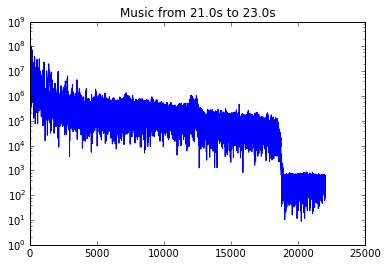

In [43]:
frequencies = np.arange(0, len(ffted_left)/2)
frequencies = frequencies * audiofile.frame_rate / len(ffted_left)
plt.plot(frequencies, np.abs(ffted_left)[0:len(ffted_left)/2]);
plt.yscale('log', nonposy='clip')
plt.title("Music from %.1fs to %.1fs" % (
        trumpets.start / audiofile.frame_rate,
        trumpets.stop / audiofile.frame_rate));

In [40]:
trumpets.stop

1014300

In [36]:
IPython.display.Audio(data_left, rate=audiofile.frame_rate)

In [18]:
data.shape

(19956528,)

In [21]:
import theano_lstm

Exception ignored in: <bound method Wave_write.__del__ of <wave.Wave_write object at 0x10dab8f98>>
Traceback (most recent call last):
  File "/usr/local/Cellar/python3/3.4.3/Frameworks/Python.framework/Versions/3.4/lib/python3.4/wave.py", line 315, in __del__
    self.close()
  File "/usr/local/Cellar/python3/3.4.3/Frameworks/Python.framework/Versions/3.4/lib/python3.4/wave.py", line 433, in close
    self._ensure_header_written(0)
  File "/usr/local/Cellar/python3/3.4.3/Frameworks/Python.framework/Versions/3.4/lib/python3.4/wave.py", line 452, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


In [ ]:
theano_lstm.Layer(100, 